# NGC7753

In this notebook we present the HI observations of the galaxy ngc7753 made with the Westerbork radio telescope. NGC7753 is a spiral galaxy located in the constellation Pegasus. It is part of the NGC 7753 group of galaxies, which also includes NGC 7752 and USNOA2-1125-19940303. The galaxy is approximately 100 million light-years away from Earth and has an apparent magnitude of around 13.5.

Authors: Angel Salazar & Quray Potosí

In [1]:
import  numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS

from reproject import reproject_interp
from astroquery.skyview import SkyView
from astroquery.vizier import Vizier
from spectral_cube import SpectralCube
import glob
from PIL import Image
import os
from IPython import display

Set the directory of the files

In [2]:
directory="/home/angeldavid/Desktop/Fedora/RESEARCH-INTERSHIPS/data_cubes/NGC7753/"
cube='S2349+2904_HIcube2_clean_smooth_image_5_cube_kms.fits'
mask='S2349+2904_HIcube2_clean_smooth_image_5_mask_kms.fits'

In [3]:
def read_fits_cube(path_file):
    hdul = fits.open(path_file)
    header = hdul[0].header
    data = hdul[0].data
    return header, data

In [4]:
# import data cubes 
header_cube,data_cube=read_fits_cube(directory+cube)
header_mask,data_mask=read_fits_cube(directory+mask)

In [5]:
# apply the mask
masked_data=np.where(data_mask,data_cube,0)

## Integrated Intensity (Moment 0)

In [6]:
mom0_dat = np.nansum(masked_data,axis=0)*abs(header_cube['CDELT3'])/1000

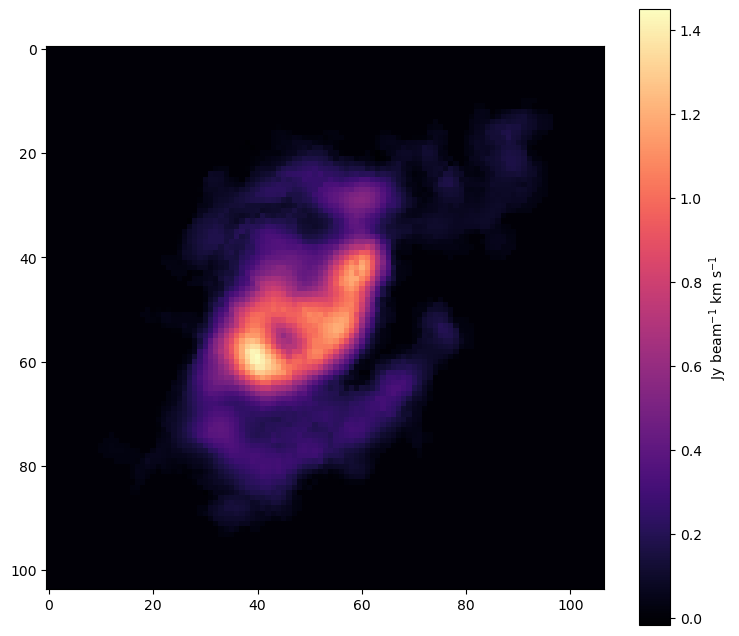

In [7]:
plt.figure(figsize=(9,8))
plt.imshow(mom0_dat,cmap='magma')
plt.colorbar(label=r'Jy beam$^{-1}$ km s$^{-1}$')
plt.show()

In [8]:
# saving the data in a afits file
def save_data(h_1,moment,data_mom):
    '''
    -h_1 is the header of the original data cube
    -moment is the name of the  map, this will be used to give the name for the fits file
    -data_mom is the data of the moment map
    '''
    wcs_new = WCS(naxis=2)
    wcs_new.wcs.cdelt = [h_1['CDELT1'], h_1['CDELT2']]
    wcs_new.wcs.ctype = [h_1['CTYPE1'], h_1['CTYPE2']]
    wcs_new.wcs.crval = [h_1['CRVAL1'], h_1['CRVAL2']]
    wcs_new.wcs.crpix = [h_1['CRPIX1'], h_1['CRPIX2']]
    header = wcs_new.to_header()        
    
# add the data and the header to an object that can be written into a file 
    hdul_new = fits.PrimaryHDU(data_mom, header=header) 
    hdul_new.writeto(directory+'{}_.fits'.format(f'ngc7753_{moment}'),overwrite=True)

In [9]:

save_data(header_cube,'mom0',mom0_dat)

In [10]:
mom0_file = "ngc7753_mom0_.fits"
header_mom0,data_mom0 = read_fits_cube(directory+mom0_file)

**Get the optical image for NGC7753, the web where we can find the galaxy image is : https://skyview.gsfc.nasa.gov/current/cgi/query.pl**  
We are going to do and overlay of the moment 0 map with on an optical image of the galaxy, for this we are going to grab an image from an online data base based on the coordinates of the HI data cube. Then we are going to grid the images to eachother to mathc the pixels and make the overlay

In [11]:
# get the central coordinate of the image
c = SkyCoord(header_mom0['CRVAL1'],header_mom0['CRVAL2'],unit='deg')
print(c.to_string('hmsdms'))

23h48m59.80617552s +29d04m15.6075168s


In [12]:
# this line grabs the image from the remote server 
#path = SkyView.get_images(position=c.to_string('hmsdms'),survey=['DSS2 Blue'],pixels=[300,300])
#hdult_opt=path[0]
#data_optical=hdul_opt[0].data
#header_optical=hdul_opt[0].header
#plt.imshow(data_optical)

**Second Option**  
We can download the optical image directly from the web source as fits file

In [13]:
optical_file='ngc7753-optical.fits'
header_optical,data_optical=read_fits_cube(directory+optical_file)


In [14]:
#test_data = fits.getdata(directory+optical_file)
#plt.imshow(test_data)

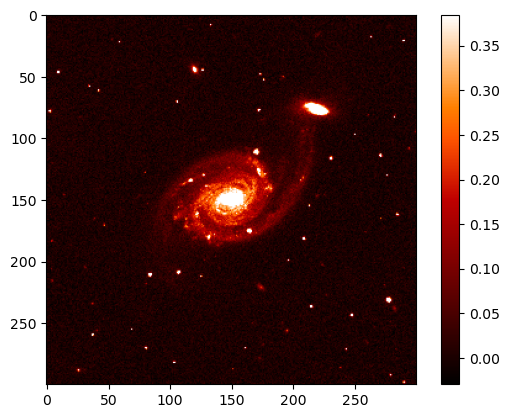

In [15]:
vmin, vmax = np.percentile(data_optical, [1, 99.5])
plt.imshow(data_optical, cmap='gist_heat', vmin=vmin, vmax=vmax)
plt.colorbar()
plt.show()


**Reproject the HI image onto the same pixel grid as the optical image**

In [16]:
def calc_rms(x):
    rms = np.sqrt(np.nanmean(x**2))
    return rms

In [17]:
hdul_mom0=fits.open(directory+mom0_file)
hi_reprojected_0,footprint = reproject_interp(hdul_mom0,header_optical)
rms_mom0 = np.sqrt(np.nanmean(hi_reprojected_0**2))

In [18]:
print(rms_mom0)
print(np.nanmax(hi_reprojected_0))

0.4064885309989523
1.447792649269104


In [43]:
#fig=plt.figure(figsize=(9,8))
#ax = fig.add_subplot(1,1,1, projection=WCS(header_mom0))
#cb=ax.imshow(data_optical,cmap='gist_heat',vmin=vmin,vmax=vmax,origin='lower')
#ax.contour(hi_reprojected_0,levels=np.arange(0,2.8,0.2)*rms_mom0,cmap='Blues_r')
#ax.contour(hi_reprojected_0, levels=15,cmap='Blues_r')
#ax.set_xlabel('RA', size=18,family='serif')
#ax.set_ylabel('Dec', size=18,family='serif')
#cbar=fig.colorbar(cb,ax=ax)
#plt.xticks(fontsize=15)
#plt.yticks(fontsize=15)
#plt.show()  

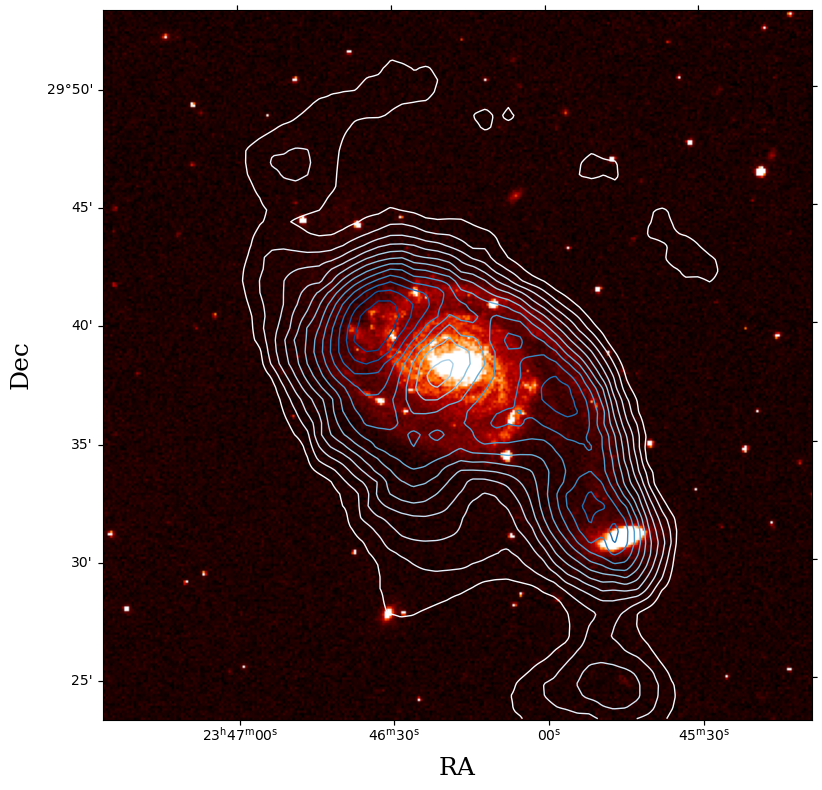

In [23]:

fig = plt.figure(figsize=(9, 8))
ax = fig.add_subplot(1, 1, 1, projection=WCS(header_mom0))

# Background: Optical image with good contrast
cb = ax.imshow(
    data_optical,
    cmap='gist_heat',  # Better contrast than 'gist_heat'
    origin='lower',
    vmin=vmin, vmax=vmax,
)

# Contour levels from 3σ to max (or use log scale)
levels = np.linspace(0.7 * rms_mom0, np.max(hi_reprojected_0), 13)

# Contour overlay in white or cyan for visibility
ax.contour(
    hi_reprojected_0,
    levels=levels,
    cmap='Blues',  # Or 'white', 'orange', or a colormap
    linewidths=1,
)

# Labels and ticks
ax.set_xlabel('RA', size=18, family='serif')
ax.set_ylabel('Dec', size=18, family='serif')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

# 🎨 Optional colorbar (if helpful)
# cbar = fig.colorbar(cb, ax=ax)
# cbar.set_label('Optical intensity', size=14)

plt.tight_layout()
plt.show()

## Velocity Field (Moment 1 map)

In [24]:
def compute_moment1(data,header,mom0data):
    d_1_av=np.nansum(data[:,:,:],axis=1)
    d_av=np.nansum(d_1_av[:,:],axis=1)
    spectra=d_av[:-3]
    x_axis=(np.arange(0,len(spectra))*header['CDELT3']+(header['CRVAL3']-header['CRPIX3']*header['CDELT3']))/1000
    d_for_mom1=data.copy()
    for i in range(len(x_axis)):
        d_for_mom1[i,:,:] = x_axis[i]*d_for_mom1[i,:,:]
    d_mom1=np.nansum(d_for_mom1,axis=0)*abs(header['CDELT3'])/(mom0data*1000)
    return d_mom1


In [25]:
# moment1
computed_mom1_dat=compute_moment1(masked_data,header_cube,data_mom0)

/tmp/ipykernel_8661/3855941281.py:9: RuntimeWarning: invalid value encountered in divide
  d_mom1=np.nansum(d_for_mom1,axis=0)*abs(header['CDELT3'])/(mom0data*1000)


In [26]:
print(np.nanmin(computed_mom1_dat),np.nanmax(computed_mom1_dat))
print()

4757.7983 5761.1665



Now we are going to do the reprojection with the optical image

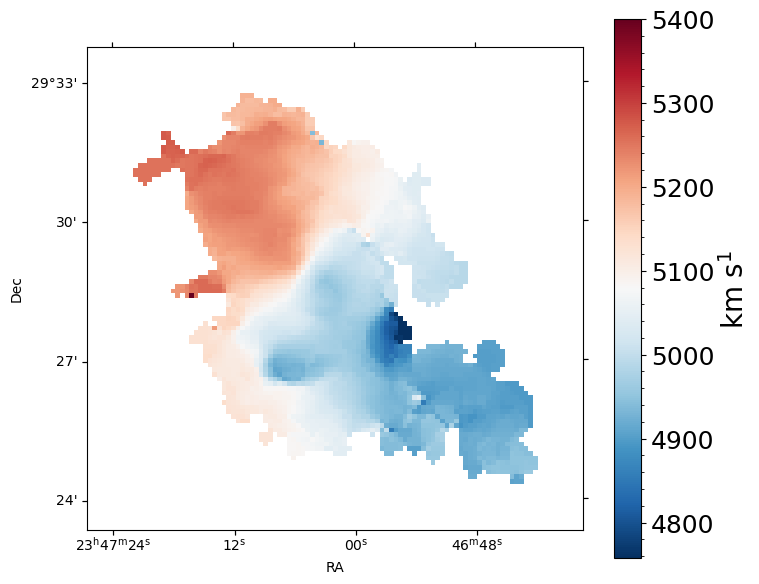

In [27]:
fig = plt.figure(figsize= (8,7))
ax=fig.add_subplot(1,1,1,projection=(WCS(header_mom0)))
cb=plt.imshow(computed_mom1_dat,cmap='RdBu_r',vmin=4757.7983,vmax=5400)
ax.set_xlabel('RA')
ax.set_ylabel('Dec')
cbar=fig.colorbar(cb)
cbar.minorticks_on()
cbar.ax.tick_params(labelsize=18)
cbar.ax.set_ylabel(r'km s$^{1}$',fontsize=20)
plt.show()

We are going to save the data for the moment 1 

In [28]:
save_data(header_cube,'mom1',computed_mom1_dat)

In [29]:
# import data for the moment 1 
mom1_file='ngc7753_mom1_.fits'
header_mom1,data_mom1=read_fits_cube(directory+mom1_file)
hdulmom1=fits.open(directory+mom1_file)

In [30]:
# compute the reprojection 
hi_mom1_rep, foot_mom1=reproject_interp(hdulmom1,header_optical)
rms_mom1=(np.sqrt(np.nanmean(hi_mom1_rep**2)))

In [31]:
print(np.nanmin(hi_mom1_rep),np.nanmax(hi_mom1_rep))
print(rms_mom1)

4757.79833984375 5668.8876953125
5085.062215553603


**Overlay of the optical image and the moment 1 map (velocity field)**

In [42]:
#fig = plt.figure(figsize=(8,7))
#ax = fig.add_subplot(1,1,1, projection=WCS(header_mom1))
#ax.imshow(data_optical, cmap='gist_gray',vmax=np.percentile(data_optical, 99.8))
#ax.contour(hi_mom1_rep, levels=10,cmap='RdBu_r')
#ax.contour(hi_mom1_rep, levels=np.arange(4800,5300,25),cmap='RdBu_r')
#ax.contour(hi_reprojected, levels=10,cmap='Blues_r')
#ax.set_xlabel('RA', size=18,family='serif')
#ax.set_ylabel('Dec', size=18,family='serif')
#plt.xticks(fontsize=15)
#plt.yticks(fontsize=15)
#plt.title('Overlay of the velocity field with the optical image')
#plt.savefig('mom1.svg')
#plt.show()

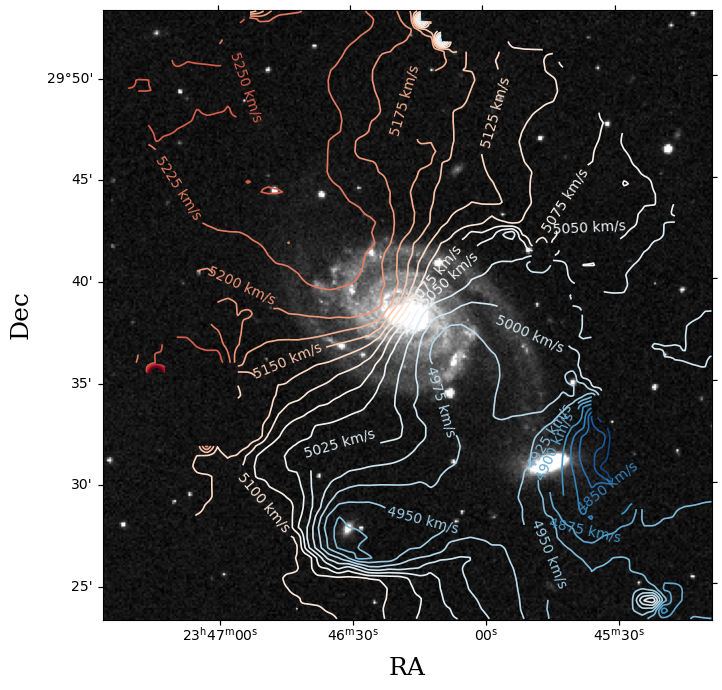

In [41]:
from astropy.visualization import simple_norm
fig = plt.figure(figsize=(8, 7))
ax = fig.add_subplot(1, 1, 1, projection=WCS(header_mom1))

# Use log stretch for better contrast in faint structures
norm = simple_norm(data_optical, 'log', percent=99.5)
ax.imshow(data_optical, cmap='gist_gray', vmin=vmin,vmax=vmax, origin='lower')

# Velocity field (moment 1) contours: reversed RdBu, centered around systemic velocity
# Adjust levels if needed based on your specific velocity range
vel_min, vel_max = 4750, 5400  # You can automate this with np.nanmin/max if desired
levels = np.arange(vel_min, vel_max, 25)
cont = ax.contour(hi_mom1_rep, levels=levels, cmap='RdBu_r', linewidths=1.2)

# Add a colorbar for the moment 1 contours (velocity field)
# Optional: only makes sense if you use contourf, otherwise label contours
ax.clabel(cont, inline=True, fmt='%d km/s', fontsize=10)

# Axis labels and ticks
ax.set_xlabel('RA', size=18, family='serif')
ax.set_ylabel('Dec', size=18, family='serif')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

# Optional title or export
# ax.set_title('Velocity Field Overlay on Optical Image', fontsize=16)
# plt.savefig('velocity_overlay.svg', dpi=300)

plt.tight_layout()
plt.show()

## Velocity Dispersion (Moment 2)

In [45]:
def compute_moment2(data,header,moment1_dat,moment0_dat):
    d_1_av=np.nansum(data[:,:,:],axis=1)
    d_av=np.nansum(d_1_av[:,:],axis=1)
    spectra=d_av[:-3]
    x_axis=(np.arange(0,len(spectra))*header['CDELT3']+(header['CRVAL3']-header['CRPIX3']*header['CDELT3']))/1000
    d_for_mom2=masked_data.copy()
    for i in range(len(x_axis)):
        d_for_mom2[i,:,:]=(x_axis[i]-moment1_dat)**2 * d_for_mom2[i,:,:]
    d_mom2 = np.sqrt(np.nansum(d_for_mom2, axis=0)*(abs(header['CDELT3'])/(moment0_dat*1000)))
    return d_mom2

In [46]:
computed_mom2_dat=compute_moment2(masked_data,header_cube,data_mom1,data_mom0)

/tmp/ipykernel_8661/3002096206.py:9: RuntimeWarning: divide by zero encountered in divide
  d_mom2 = np.sqrt(np.nansum(d_for_mom2, axis=0)*(abs(header['CDELT3'])/(moment0_dat*1000)))
/tmp/ipykernel_8661/3002096206.py:9: RuntimeWarning: invalid value encountered in multiply
  d_mom2 = np.sqrt(np.nansum(d_for_mom2, axis=0)*(abs(header['CDELT3'])/(moment0_dat*1000)))
/tmp/ipykernel_8661/3002096206.py:9: RuntimeWarning: invalid value encountered in sqrt
  d_mom2 = np.sqrt(np.nansum(d_for_mom2, axis=0)*(abs(header['CDELT3'])/(moment0_dat*1000)))


Save data for moment 2

In [47]:
save_data(header_cube,'mom2',computed_mom2_dat)

In [48]:
mom2_file='ngc7753_mom2_.fits'
header_mom2,data_mom2=read_fits_cube(directory+mom2_file)
hdulmom2=fits.open(directory+mom2_file)

In [49]:
hi_mom2_rep, foot_mom2=reproject_interp(hdulmom2,header_optical)
rms_mom2=(np.sqrt(np.nanmean(hi_mom1_rep**2)))

In [50]:
print(rms_mom2)
print(np.nanmin(hi_mom2_rep),np.nanmax(hi_mom2_rep))

5085.062215553603
1.4034716514288448e-05 112.88147735595703


In [55]:
#fig = plt.figure(figsize=(8,7))
#ax = fig.add_subplot(1,1,1, projection=WCS(header_mom2))
#ax.imshow(data_optical, cmap='gist_heat',vmax=np.percentile(data_optical, 99.8))
#ax.contour(hi_mom1_rep, levels=10,cmap='RdBu_r')
#ax.contour(hi_mom2_rep, levels=np.arange(0,114,10),cmap='viridis')
#ax.contour(hi_reprojected, levels=10,cmap='Blues_r')
#ax.set_xlabel('RA', size=18,family='serif')
#ax.set_ylabel('Dec', size=18,family='serif')
#plt.xticks(fontsize=15)
#plt.yticks(fontsize=15)
#plt.title('Overlay of the velocity field with the optical image')
#plt.savefig('mom1.svg')
#plt.show()

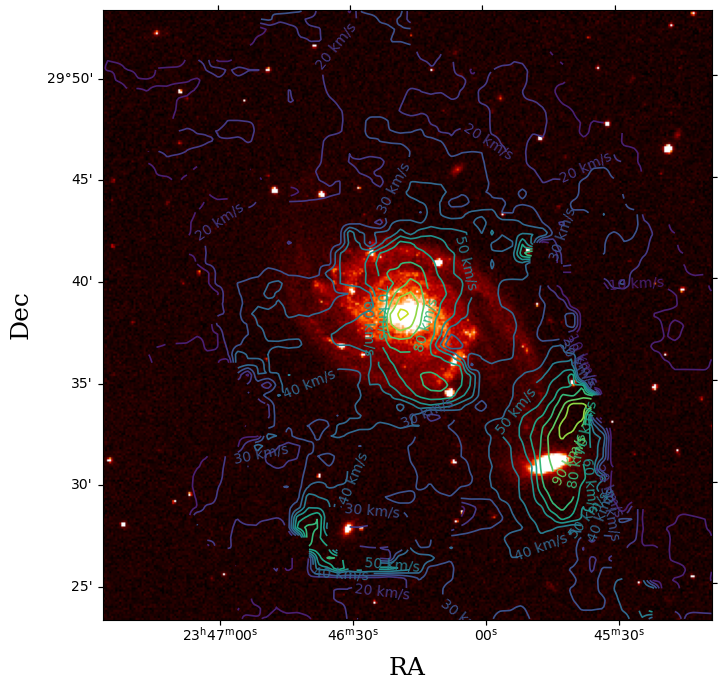

In [54]:
fig = plt.figure(figsize=(8, 7))
ax = fig.add_subplot(1, 1, 1, projection=WCS(header_mom2))

# Improve optical background contrast
norm = simple_norm(data_optical, 'log', percent=99.5)
ax.imshow(data_optical, cmap='gist_heat', vmin=vmin,vmax=vmax, origin='lower')

# Contours for moment 2 (velocity dispersion)
disp_min, disp_max = 0, 113  # in km/s (check your units)
levels = np.arange(disp_min, disp_max + 10, 10)
cont = ax.contour(hi_mom2_rep, levels=levels, cmap='viridis', linewidths=1.2)

# Optional: Label the contours
ax.clabel(cont, inline=True, fmt='%d km/s', fontsize=10)

# Axis formatting
ax.set_xlabel('RA', size=18, family='serif')
ax.set_ylabel('Dec', size=18, family='serif')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

# Optional: Export or annotate
# ax.set_title('Velocity Dispersion Overlay on Optical Image', fontsize=16)
# plt.savefig('moment2_overlay.svg', dpi=300)

plt.tight_layout()
plt.show()

## BBarolo Model and Comparison

In [56]:
file_model = "/output/SoFiA_J234703.61+292835.6/SoFiA_J234703.61+292835.6mod_azim.fits"

In [57]:
header_model, data_model = read_fits_cube(directory + file_model)


***Moment 0 map with BBarolo Model***

In [58]:
mom0_dat_model = np.nansum(data_model,axis=0)*abs(header_model['CDELT3'])/1000

***Moment 1 map with BBarolo Model***

In [59]:
mom1_dat_model = compute_moment1(data_model, header_model, mom0_dat_model)

/tmp/ipykernel_8661/3855941281.py:9: RuntimeWarning: invalid value encountered in divide
  d_mom1=np.nansum(d_for_mom1,axis=0)*abs(header['CDELT3'])/(mom0data*1000)


***Moment 2 map with BBarolo Model***

In [60]:
mom2_dat_model = compute_moment2(data_model, header_model,mom0_dat_model ,mom1_dat_model)

/tmp/ipykernel_8661/3002096206.py:9: RuntimeWarning: invalid value encountered in sqrt
  d_mom2 = np.sqrt(np.nansum(d_for_mom2, axis=0)*(abs(header['CDELT3'])/(moment0_dat*1000)))


Calculate the residuals of the model 

In [61]:
residual_mom0 = mom0_dat -mom0_dat_model
residual_mom1 = computed_mom1_dat - mom1_dat_model
residual_mom2 = computed_mom2_dat - mom2_dat_model

**Maps of the data, model, and residual of each moment**

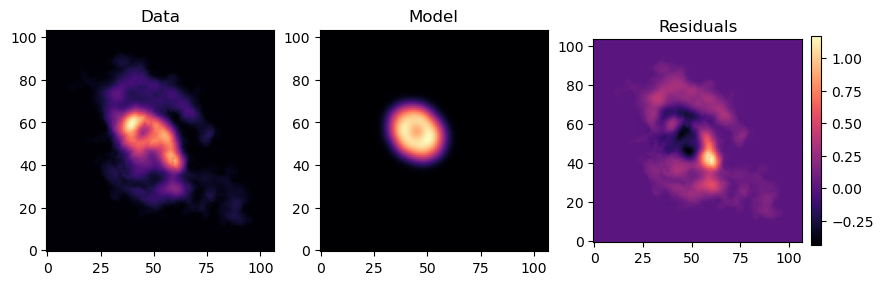

In [62]:

fig, axs = plt.subplots(1, 3, figsize=(10, 17))
im1 = axs[0].imshow(mom0_dat, cmap='magma')
axs[0].set_title('Data')
im2 = axs[1].imshow(mom0_dat_model, cmap='magma')
axs[1].set_title('Model')
im3 = axs[2].imshow(residual_mom0, cmap='magma')
axs[2].set_title('Residuals')
cbar = fig.colorbar(im3, ax=axs[2], fraction=0.046, pad=0.04)
for ax in axs:
    ax.invert_yaxis()

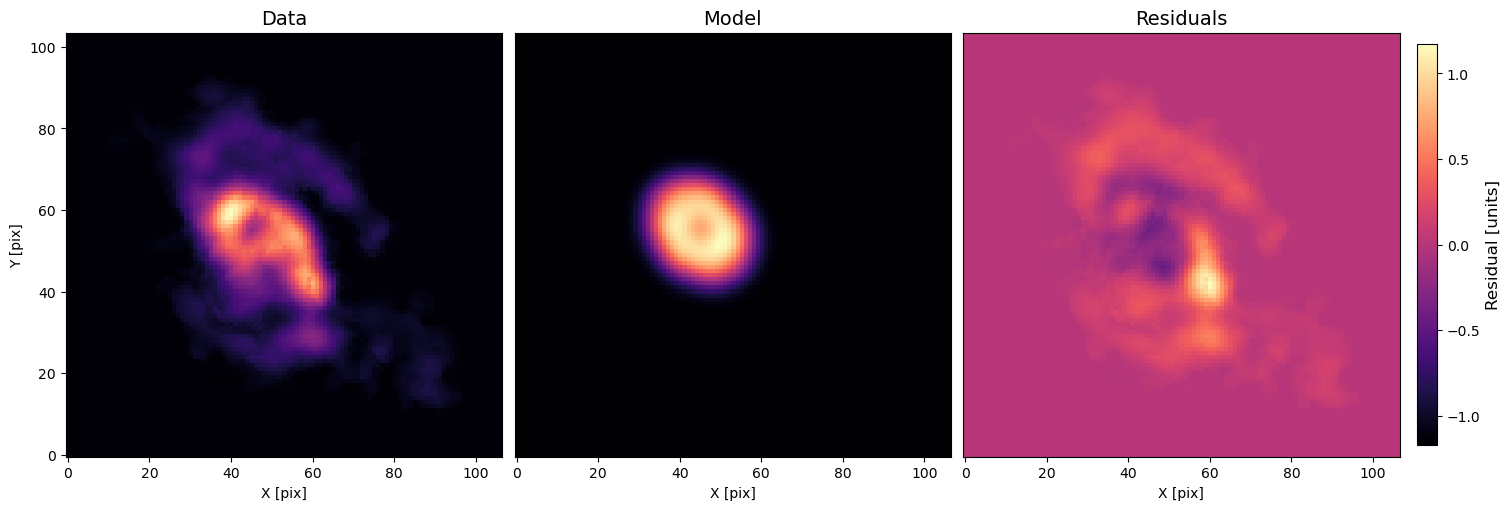

In [64]:

# Set up figure and axes
fig, axs = plt.subplots(1, 3, figsize=(15, 5), constrained_layout=True)

# Common kwargs
common_kwargs = dict(origin='lower', interpolation='none')

# Panel 1 – Data
im1 = axs[0].imshow(mom0_dat, cmap='magma', **common_kwargs)
axs[0].set_title('Data', fontsize=14)
axs[0].set_xlabel('X [pix]')
axs[0].set_ylabel('Y [pix]')

# Panel 2 – Model
im2 = axs[1].imshow(mom0_dat_model, cmap='magma', **common_kwargs)
axs[1].set_title('Model', fontsize=14)
axs[1].set_xlabel('X [pix]')
axs[1].set_yticks([])  # Hide y-axis on center plot

# Panel 3 – Residuals
vmin, vmax = np.nanmin(residual_mom0), np.nanmax(residual_mom0)
# Center colormap around 0 for residuals
resid_abs_max = np.nanmax(np.abs(residual_mom0))
im3 = axs[2].imshow(residual_mom0, cmap='magma', vmin=-resid_abs_max, vmax=resid_abs_max, **common_kwargs)
axs[2].set_title('Residuals', fontsize=14)
axs[2].set_xlabel('X [pix]')
axs[2].set_yticks([])

# Shared colorbar for residuals
cbar = fig.colorbar(im3, ax=axs[2], fraction=0.046, pad=0.04)
cbar.set_label('Residual [units]', fontsize=12)

# Optional improvements
for ax in axs:
    ax.tick_params(labelsize=10)
    ax.set_aspect('equal')

# Save/export
# plt.savefig('mom0_comparison.pdf', dpi=300)
plt.show()

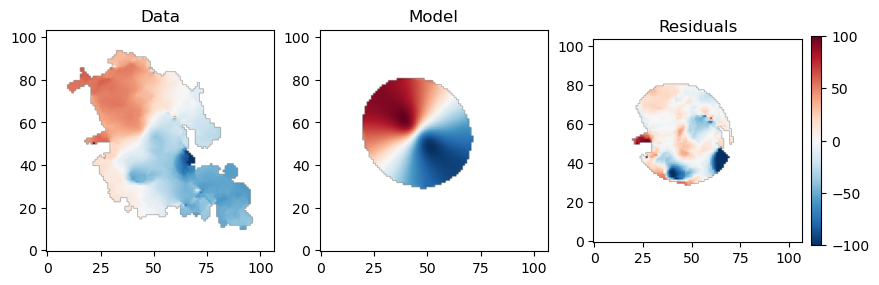

In [69]:
fig, axs = plt.subplots(1, 3, figsize=(10, 17))
im1 = axs[0].imshow(computed_mom1_dat, cmap='RdBu_r',vmin=4757.7983,vmax=5400)
axs[0].set_title('Data')
im2 = axs[1].imshow(mom1_dat_model, cmap='RdBu_r')
axs[1].set_title('Model')
im3 = axs[2].imshow(residual_mom1, cmap='RdBu_r', vmax=100, vmin=-100)
axs[2].set_title('Residuals')
cbar = fig.colorbar(im3, ax=axs[2], fraction=0.046, pad=0.04)
for ax in axs:
    ax.invert_yaxis()

In [73]:
print(np.nanmin(mom1_dat_model),np.nanmax(mom1_dat_model))

4956.333 5236.6455


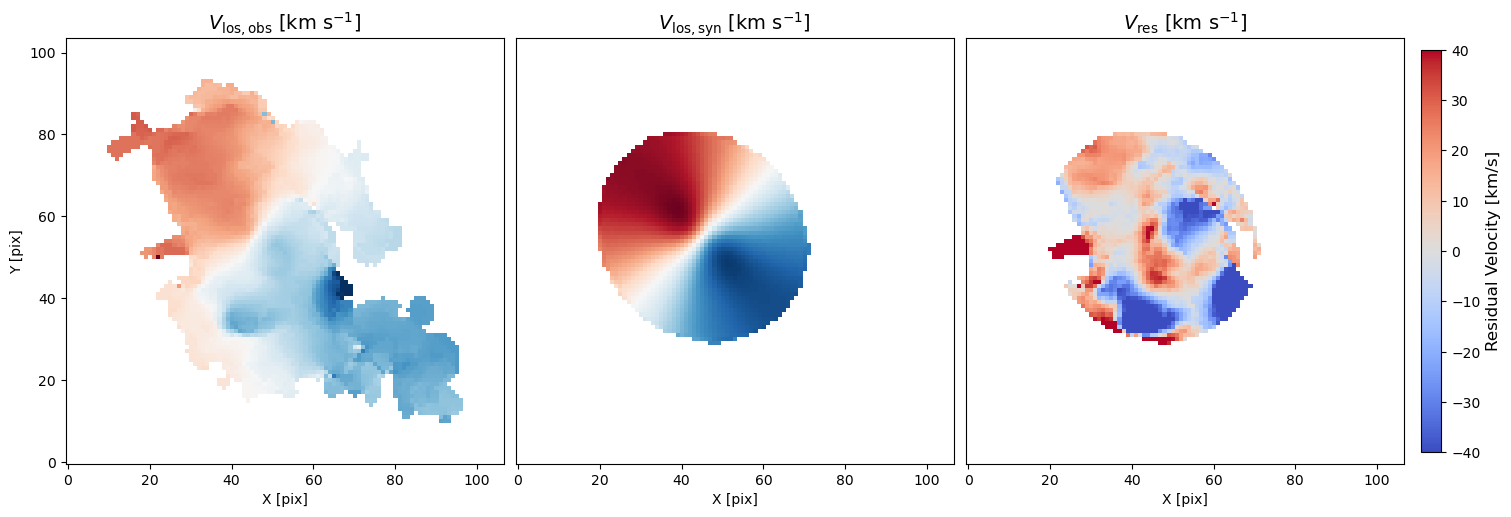

In [75]:

# Figure setup
fig, axs = plt.subplots(1, 3, figsize=(15, 5), constrained_layout=True)

# Common kwargs for cleaner imshow
common_kwargs = dict(origin='lower', interpolation='none')

# Panel 1 – Data
im1 = axs[0].imshow(computed_mom1_dat, cmap='RdBu_r', vmin=4757.7983,vmax=5400, **common_kwargs)
axs[0].set_title(r'$V_{\mathrm{los,obs}}$ [km s$^{-1}$]', fontsize=14)
axs[0].set_xlabel('X [pix]')
axs[0].set_ylabel('Y [pix]')

# Panel 2 – Model
im2 = axs[1].imshow(mom1_dat_model, cmap='RdBu_r', vmin=4950, vmax=5240, **common_kwargs)
axs[1].set_title(r'$V_{\mathrm{los,syn}}$ [km s$^{-1}$]', fontsize=14)
axs[1].set_xlabel('X [pix]')
axs[1].set_yticks([])

# Panel 3 – Residuals
# Force symmetric scale around 0 for velocity residuals
resid_vlim = 40  # km/s
im3 = axs[2].imshow(residual_mom1, cmap='coolwarm',vmin=-resid_vlim, vmax=resid_vlim ,**common_kwargs)
axs[2].set_title(r'$V_{\mathrm{res}}$ [km s$^{-1}$]', fontsize=14)
axs[2].set_xlabel('X [pix]')
axs[2].set_yticks([])

# Colorbar for residuals
cbar = fig.colorbar(im3, ax=axs[2], fraction=0.046, pad=0.04)
cbar.set_label('Residual Velocity [km/s]', fontsize=12)

# Optional enhancements
for ax in axs:
    ax.tick_params(labelsize=10)
    ax.set_aspect('equal')

# Optional export
# plt.savefig('moment1_comparison.pdf', dpi=300)
plt.show()

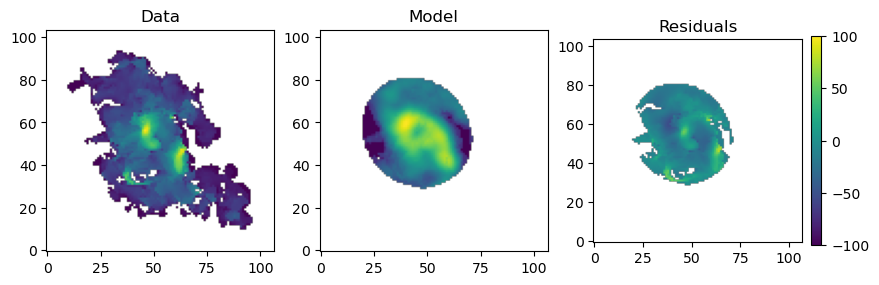

In [46]:
fig, axs = plt.subplots(1, 3, figsize=(10, 15))
im1 = axs[0].imshow(computed_mom2_dat, cmap='viridis')
axs[0].set_title('Data')
im2 = axs[1].imshow(mom2_dat_model, cmap='viridis')
axs[1].set_title('Model')
im3 = axs[2].imshow(residual_mom2, cmap='viridis',vmin=-100,vmax=100)
axs[2].set_title('Residuals')
cbar = fig.colorbar(im3, ax=axs[2], fraction=0.046, pad=0.04)
for ax in axs:
    ax.invert_yaxis()

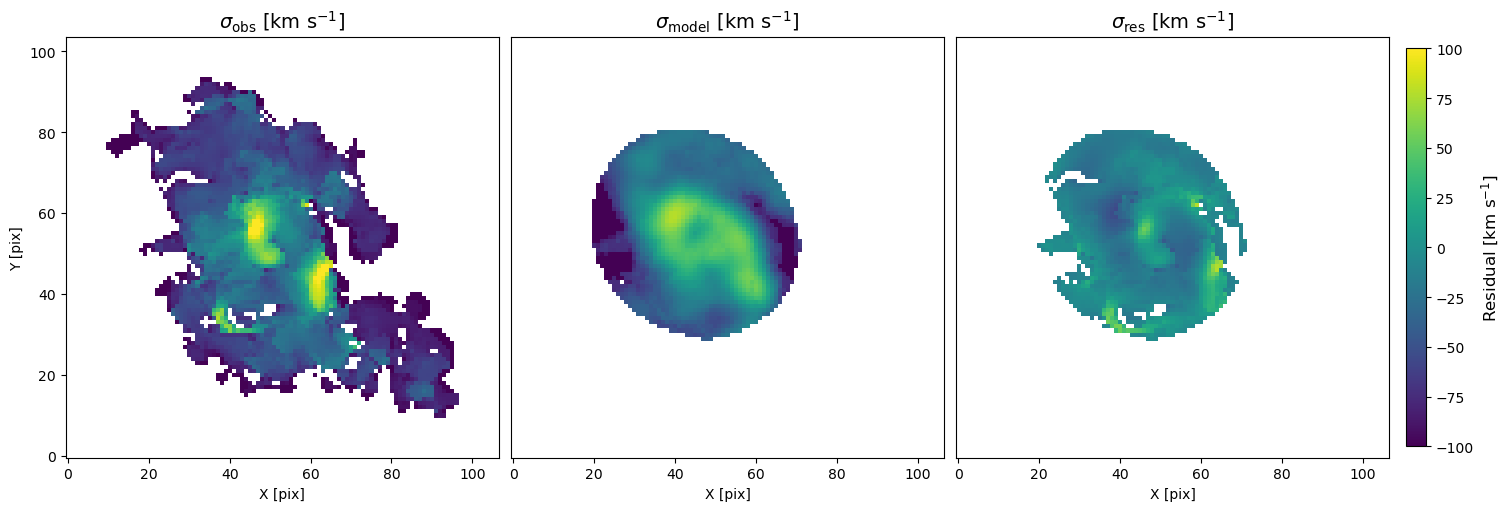

In [77]:

# Create figure and axes
fig, axs = plt.subplots(1, 3, figsize=(15, 5), constrained_layout=True)

# Shared kwargs for consistent image rendering
common_kwargs = dict(origin='lower', interpolation='none')

# Panel 1 – Data
vmin_m2 = 0
vmax_m2 = np.nanpercentile(computed_mom2_dat, 99.5)
im1 = axs[0].imshow(computed_mom2_dat, cmap='viridis', vmin=vmin_m2, vmax=vmax_m2, **common_kwargs)
axs[0].set_title(r'$\sigma_{\mathrm{obs}}$ [km s$^{-1}$]', fontsize=14)
axs[0].set_xlabel('X [pix]')
axs[0].set_ylabel('Y [pix]')

# Panel 2 – Model
im2 = axs[1].imshow(mom2_dat_model, cmap='viridis', vmin=vmin_m2, vmax=vmax_m2, **common_kwargs)
axs[1].set_title(r'$\sigma_{\mathrm{model}}$ [km s$^{-1}$]', fontsize=14)
axs[1].set_xlabel('X [pix]')
axs[1].set_yticks([])

# Panel 3 – Residuals (symmetrically centered around 0)
resid_lim = 100  # km/s
im3 = axs[2].imshow(residual_mom2, cmap='viridis', vmin=-resid_lim, vmax=resid_lim, **common_kwargs)
axs[2].set_title(r'$\sigma_{\mathrm{res}}$ [km s$^{-1}$]', fontsize=14)
axs[2].set_xlabel('X [pix]')
axs[2].set_yticks([])

# Colorbar for residuals
cbar = fig.colorbar(im3, ax=axs[2], fraction=0.046, pad=0.04)
cbar.set_label('Residual [km s$^{-1}$]', fontsize=12)

# Final touches
for ax in axs:
    ax.tick_params(labelsize=10)
    ax.set_aspect('equal')

# Optional export
# plt.savefig('moment2_comparison.pdf', dpi=300)
plt.show()

## Prepare the data to isolate the companion galaxy

In [47]:
data_new_galaxy = data_cube - data_model

In [48]:
mom0_dat_new = np.nansum(data_new_galaxy,axis=0)*abs(header_model['CDELT3'])/1000

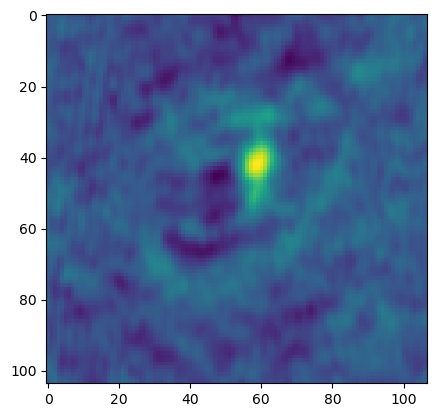

In [49]:
# quick inspection 
plt.imshow(mom0_dat_new)

In [51]:
directory_new = "/home/angeldavid/Desktop/Fedora/RESEARCH-INTERSHIPS/data_cubes/NGC7752/"
hdul_new = fits.PrimaryHDU(data_new_galaxy,header=header_cube)
hdul_new.writeto(directory_new + 'ngc7752_cube.fits', overwrite=True)

## Rotation Curves

In [52]:
import pandas as pd

In [61]:
rig_model_file = "output/SoFiA_J234703.61+292835.6/SoFiA_J234703.61+292835.6_2drings.txt"


In [62]:
rot_curve_data=pd.read_csv(directory+rig_model_file,delim_whitespace=True,on_bad_lines='skip')

/tmp/ipykernel_5518/3820888872.py:1: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  rot_curve_data=pd.read_csv(directory+rig_model_file,delim_whitespace=True,on_bad_lines='skip')


In [108]:
rot_curve_data

,Radius,Radius.1,Vsys,Vrot,Vexp,P.A.,Incl.,Xcenter,Ycenter,0
0,[pix],1,[KM/S],1,[KM/S],[deg],[deg],[pix],[pix],0
1,0.42,2.50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,1.25,7.50,5088.81,125.83,0.00,60.90,37.00,45.00,55.00,0
3,2.08,12.50,5088.81,171.07,0.00,50.32,37.00,45.00,55.00,0
4,2.92,17.50,5088.81,187.15,0.00,61.95,37.00,45.00,55.00,0
5,3.75,22.50,5088.81,207.54,0.00,50.95,37.00,45.00,55.00,0
6,4.58,27.50,5088.81,220.89,0.00,50.91,37.00,45.00,55.00,0
7,5.42,32.50,5088.81,231.56,0.00,51.51,37.00,45.00,55.00,0
8,6.25,37.50,5088.81,238.63,0.00,52.89,37.00,45.00,55.00,0
9,7.08,42.50,5088.81,244.51,0.00,51.05,37.00,45.00,55.00,0


In [112]:
radius_arcsec = rot_curve_data['Radius.1'][2:]
rot_vel = rot_curve_data['Vrot'][2:]
#radius_arcsec.iloc[0] = 1
#rot_vel.iloc[0] = 1
radius_arcsec = radius_arcsec.astype(float)
rot_vel = rot_vel.astype(float)
radius_arcsec = np.insert(radius_arcsec.values, 0 ,0 )
rot_vel = np.insert(rot_vel.values, 0 ,0 )
print(radius_arcsec)
print(rot_vel)

[ 0.   7.5 12.5 17.5 22.5 27.5 32.5 37.5 42.5 47.5 52.5 57.5 62.5 67.5
 72.5 77.5 82.5 87.5]
[  0.   125.83 171.07 187.15 207.54 220.89 231.56 238.63 244.51 245.2
 242.4  240.21 237.74 233.89 228.73 223.58 221.69 221.29]


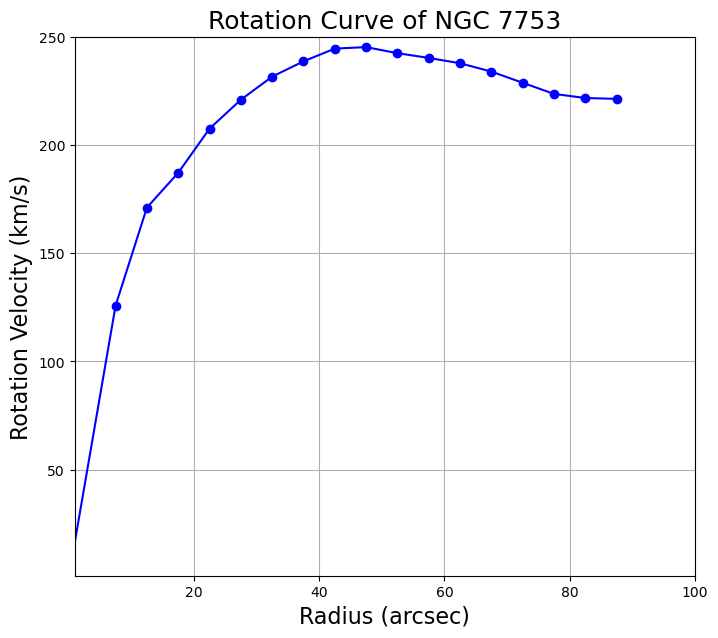

In [115]:
plt.figure(figsize=(8,7))
plt.plot(radius_arcsec,rot_vel,linestyle='-',color='blue',marker='o')
plt.xlabel('Radius (arcsec)', fontsize=16)
plt.ylabel('Rotation Velocity (km/s)', fontsize=16)
plt.title('Rotation Curve of NGC 7753', fontsize=18)
plt.ylim(1,250)
plt.xlim(1,100)
plt.grid()
plt.show()